In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Note EWKino_CLs_train.csv and EWKino_CLs_test.csv are already normalised to mean=0 and std=1 on every column that isn't CLs
train = pd.read_csv("csv-files/EWKino_CLs_train.csv")

In [14]:
def build_model(): # Returns a compiled model, as K-fold cross validation involves building the same model lots of times
    
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.005), # change to "optimizer=optimizer" if using the learning rate decay in the text block above
        loss="mse",
        metrics=["mae"]
    )
    
    return model

In [15]:
def k_fold_validation(k, num_epochs, df): # Trains model for one round of k-fold validation
    
    # Shuffle the entire training dataset
    shuffled_df = df.sample(frac=1)
    
    # Separate the inputs and target outputs into train and labels respectively
    labels = shuffled_df.pop("Final__CLs")
    train = shuffled_df
    num_val_samples = len(train) // k
    all_histories = []
    
    for i in range(k):
        # print(f"Processing fold #{i}")
        
        val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(
            [train[:i * num_val_samples],
            train[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        partial_train_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        model = build_model()
        
        history = model.fit(
            partial_train_data,
            partial_train_labels,
            epochs=num_epochs,
            validation_data=(val_data, val_labels),
            verbose=0
        )
        
        all_histories.append(history)
        
    # Average the training and validation accuracy for each epoch across the folds
    single_iter_val_accuracy = np.empty((k,num_epochs))
    single_iter_train_accuracy = np.empty((k,num_epochs))
    for i in range(k):
        single_iter_val_accuracy[i,:] = all_histories[i].history["val_mae"]
        single_iter_train_accuracy[i,:] = all_histories[i].history["mae"]
    single_iter_val_accuracy = single_iter_val_accuracy.mean(axis=0)
    single_iter_train_accuracy = single_iter_train_accuracy.mean(axis=0)
    
    return single_iter_val_accuracy, single_iter_train_accuracy

In [25]:
k = 2 # This value seems to work fine
num_epochs = 500 # When testing new models, set this high enough to see overfitting (assuming model is powerful enough to overfit)
iterations = 1 # If accuracy scores have high variance, increase iterations to 5 (smoother) or 10 (smoothest)
avg_train_accuracy = np.empty((iterations,num_epochs))
avg_val_accuracy = np.empty((iterations,num_epochs))

for i in range(iterations):
    print(f"Processing iteration #{i}")
    single_iter_val_accuracy, single_iter_train_accuracy = k_fold_validation(k, num_epochs, train)
    avg_val_accuracy[i,:] = single_iter_val_accuracy
    avg_train_accuracy[i,:] = single_iter_train_accuracy
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

Processing iteration #0


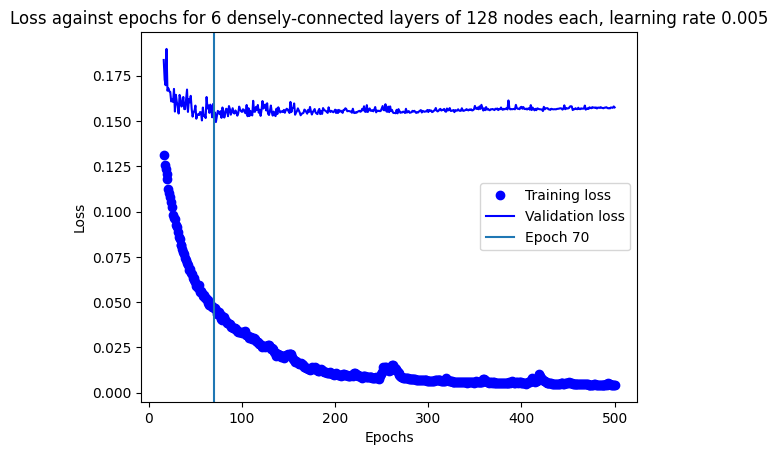

In [30]:
# Plot training and validation accuracy for each epoch

best_epoch = 70
cut = 15 # This removes first epoch (usually very incorrect) to help the graph scale correctly
epochs = range(cut+1, num_epochs + 1)
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training loss")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation loss")
plt.axvline(best_epoch, label=f"Epoch {best_epoch}")
plt.title("Loss against epochs for 6 densely-connected layers of 128 nodes each, learning rate 0.005")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("fitting_data_CLs_500_epochs.png")
plt.show()